In [39]:
library(tidyverse)
library(repr)
library(readxl)
library(GGally)

options(repr.matrix.max.rows = 6)

In [46]:
options(repr.matrix.max.rows = 16)

fb_data <- read_csv2("data/dataset_fb.csv")
colnames(fb_data) <- c("page_likes", "type", "category", "post_month", "post_weekday", "post_hour", "paid", "reach", 
      "impressions", "engaged_users", "post_consumers", "post_consumptions", "impressions_by_people_that_liked_page", 
      "reach_by_people_that_like_page", "people_liked_and_engaged", "comments", "likes", "shares", "interactions")
fb_data

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



page_likes,type,category,post_month,post_weekday,post_hour,paid,reach,impressions,engaged_users,post_consumers,post_consumptions,impressions_by_people_that_liked_page,reach_by_people_that_like_page,people_liked_and_engaged,comments,likes,shares,interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186
139441,Photo,3,12,1,3,1,11692,19479,481,265,364,15432,9328,379,3,249,27,279
139441,Photo,3,12,7,9,1,13720,24137,537,232,305,19728,11056,422,0,325,14,339
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


In [47]:
summary(fb_data)

   page_likes         type              category      post_month    
 Min.   : 81370   Length:500         Min.   :1.00   Min.   : 1.000  
 1st Qu.:112676   Class :character   1st Qu.:1.00   1st Qu.: 4.000  
 Median :129600   Mode  :character   Median :2.00   Median : 7.000  
 Mean   :123194                      Mean   :1.88   Mean   : 7.038  
 3rd Qu.:136393                      3rd Qu.:3.00   3rd Qu.:10.000  
 Max.   :139441                      Max.   :3.00   Max.   :12.000  
                                                                    
  post_weekday    post_hour          paid            reach       
 Min.   :1.00   Min.   : 1.00   Min.   :0.0000   Min.   :   238  
 1st Qu.:2.00   1st Qu.: 3.00   1st Qu.:0.0000   1st Qu.:  3315  
 Median :4.00   Median : 9.00   Median :0.0000   Median :  5281  
 Mean   :4.15   Mean   : 7.84   Mean   :0.2786   Mean   : 13903  
 3rd Qu.:6.00   3rd Qu.:11.00   3rd Qu.:1.0000   3rd Qu.: 13168  
 Max.   :7.00   Max.   :23.00   Max.   :1.0000   Max

Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removing 1 row that contained a missing value”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 1 rows containing non-finite values (stat_density).”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removing 1 row that contained a missing value”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removing 1 row that contained a missing value”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removing 1 row that contained a missing value”
`stat_bin()` usin

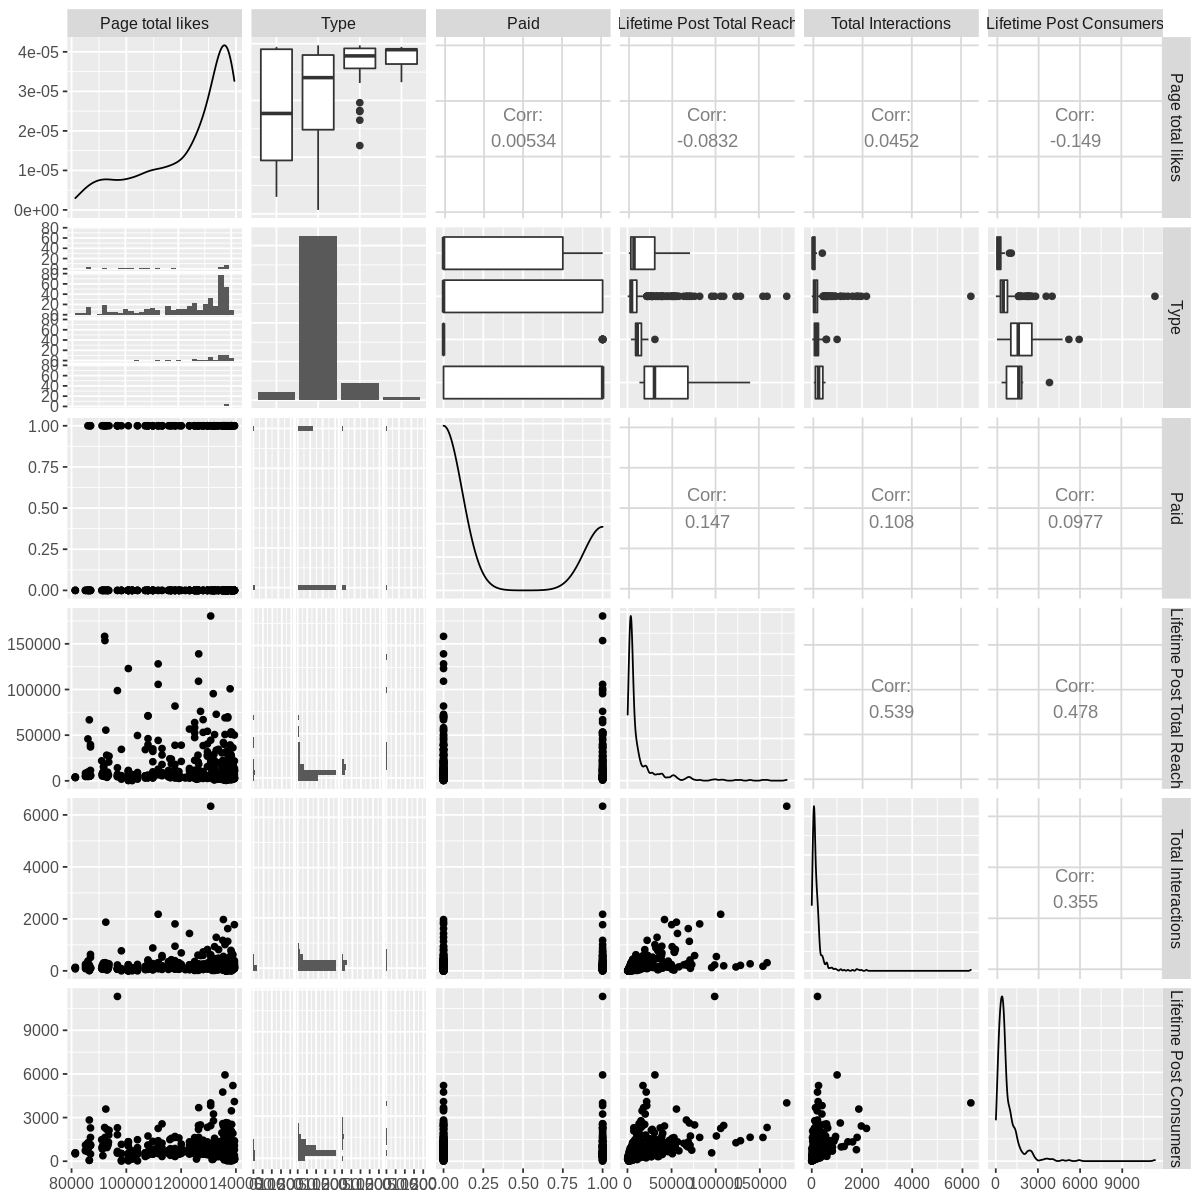

In [36]:
options(repr.plot.width = 10, repr.plot.height = 10)

fb_plot <- select(fb_data, `Page total likes` ,`Type`,`Paid`,`Lifetime Post Total Reach`, `Total Interactions`,`Lifetime Post Consumers`) %>% 
    ggpairs()+
    theme(text = element_text(size=12))

fb_plot

In [13]:
?ggpairs

No documentation for ‘ggpairs’ in specified packages and libraries:
you could try ‘??ggpairs’

In [14]:
??ggpairs’


ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected input
1: ??ggpairs’
             ^
